In [102]:
import pandas as pd
import numpy as np

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, KBinsDiscretizer, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

In [127]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

### Removing Null values

In [128]:
train_data=train_data.dropna(how='any')

### Adding Date Columns

In [129]:
def add_features(X):
    X['Date']=pd.to_datetime(X['CreationTimestamp'], unit='s')
    X['Day']=X['Date'].dt.day_name()
    X['Hour']=X['Date'].apply(lambda x: x.hour + x.minute/60)
    return X

train_data=add_features(train_data)
test_data=add_features(test_data)

In [130]:
train_data.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review', 'Date', 'Day', 'Hour'],
      dtype='object')

### Dividing data into train and validation

In [131]:
X, y=train_data.drop('Rating', axis=1), train_data['Rating']
X_test=test_data

In [132]:
X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.2, random_state=29)

### Pipeline

In [665]:
col_transform=ColumnTransformer([('scaler', StandardScaler(), ['RecipeNumber', 'UserReputation',
                                                             'ReplyCount', 'ThumbsUpCount',
                                                             'ThumbsDownCount', 'BestScore']),
                                #  ('day_encode', OneHotEncoder(), ['Day']),
                                 ('hour_encode', KBinsDiscretizer(n_bins=5, encode='onehot',
                                                                  strategy='quantile', random_state=29, subsample=None),
                                                                  ['Hour']),
                                 ('vectorizer', TfidfVectorizer(stop_words='english', max_features=2000), 'Recipe_Review')])

weights={0: 4, 1: 8, 2: 12, 3: 6, 4: 3.5, 5: 1.8}
pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', RandomForestClassifier(n_jobs=-1, random_state=29, #class_weight=weights, 
                                                   oob_score=True, max_samples=1.0, max_features=47,
                                                   n_estimators=310))])

In [666]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  TfidfVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x0000025FBCD54550>)),
                ('clsf',
                 RandomForestClassifier(max_features=47, max_samples=1.0,
                                        n_estimators=310, n_jobs=-1,
                                        oob_score=True, random_state=29))])

### Train Report

In [667]:
train_predict=pipeline.predict(X_train)

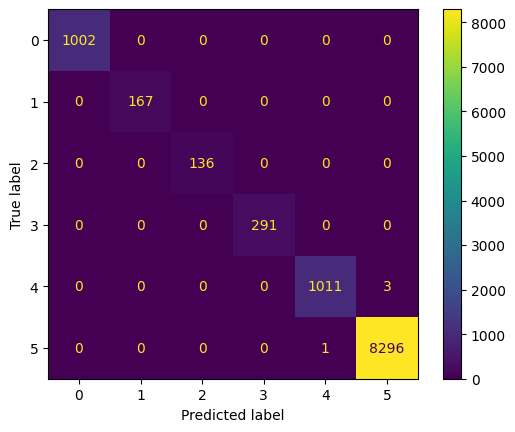

In [668]:
ConfusionMatrixDisplay.from_predictions(y_train, train_predict, display_labels=pipeline.classes_);

In [669]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1002
           1       1.00      1.00      1.00       167
           2       1.00      1.00      1.00       136
           3       1.00      1.00      1.00       291
           4       1.00      1.00      1.00      1014
           5       1.00      1.00      1.00      8297

    accuracy                           1.00     10907
   macro avg       1.00      1.00      1.00     10907
weighted avg       1.00      1.00      1.00     10907



In [670]:
accuracy_score(y_train, train_predict)

0.9996332630420831

### Test Report

In [671]:
valid_predict=pipeline.predict(X_valid)

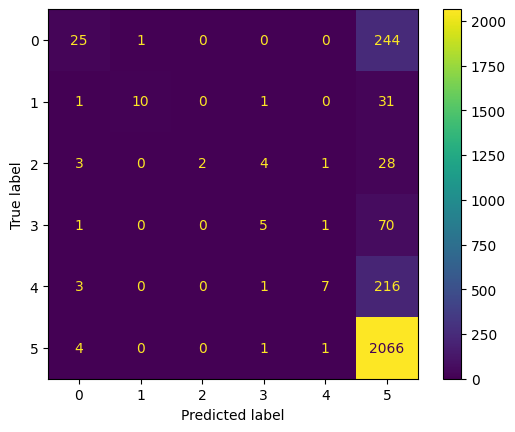

In [672]:
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);

In [673]:
print(classification_report(y_valid, valid_predict))

              precision    recall  f1-score   support

           0       0.68      0.09      0.16       270
           1       0.91      0.23      0.37        43
           2       1.00      0.05      0.10        38
           3       0.42      0.06      0.11        77
           4       0.70      0.03      0.06       227
           5       0.78      1.00      0.87      2072

    accuracy                           0.78      2727
   macro avg       0.75      0.25      0.28      2727
weighted avg       0.76      0.78      0.70      2727



In [674]:
accuracy_score(y_valid, valid_predict)

0.7755775577557755

### Grid Search Cross Validation

In [664]:
gscv=GridSearchCV(pipeline, param_grid={'clsf__n_estimators' : list(range(250,350, 10))},
                  cv=4, n_jobs=-1)
gscv.fit(X, y)
gscv.best_params_, gscv.best_score_

({'clsf__n_estimators': 310}, 0.7720405897052404)

### Training on whole dataset

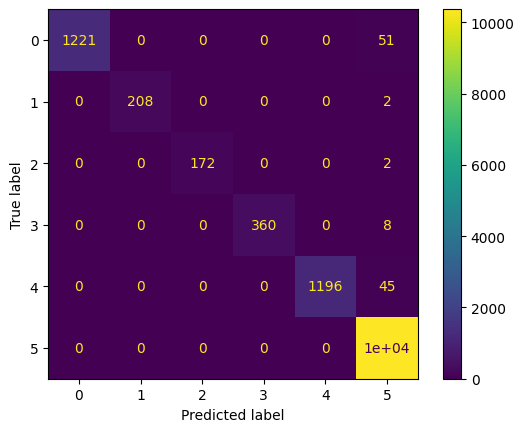

In [123]:
pipeline.fit(X, y)
whole_predict=pipeline.predict(X)
ConfusionMatrixDisplay.from_predictions(y, whole_predict, display_labels=pipeline.classes_);

In [124]:
print(classification_report(y, whole_predict))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1272
           1       1.00      0.99      1.00       210
           2       1.00      0.99      0.99       174
           3       1.00      0.98      0.99       368
           4       1.00      0.96      0.98      1241
           5       0.99      1.00      0.99     10369

    accuracy                           0.99     13634
   macro avg       1.00      0.98      0.99     13634
weighted avg       0.99      0.99      0.99     13634



In [125]:
accuracy_score(y, whole_predict)

0.9920786269620068

In [338]:
test_predict=pipeline.predict(X_test)